In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import time
from utils import load_data, split_data
from metrics import compute_accuracy
from torchsummary import summary
from train import train, trial

In [2]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
torch.manual_seed(43)
split = 5
indices = torch.randperm(10)
a_idx = indices[:split]
b_idx = indices[split:]
data = torch.tensor(list(range(10))).squeeze()

a = SubsetRandomSampler(a_idx)

In [5]:
!ls

dlc_practical_prologue.py  Project1v3.ipynb  __pycache__
metrics.py		   Project1v4.ipynb  train.py
Project1.tar.gz		   proj.tar.gz	     utils.py


In [6]:
!tar chvfz proj.tar.gz

tar: Cowardly refusing to create an empty archive
Try 'tar --help' or 'tar --usage' for more information.


In [3]:
train_loader = torch.utils.data.DataLoader(data, batch_size=1, sampler=a)

In [4]:
for i in train_loader:
    print(i)

tensor([8])
tensor([0])
tensor([4])
tensor([5])
tensor([9])


In [5]:
t = SubsetRandomSampler(train_indices)

NameError: name 'train_indices' is not defined

In [6]:
train_data, test_data = load_data()
train_loader, valid_loader, test_loader = split_data(train_data, test_data)

In [7]:
class Net(nn.Module):
    def __init__(self, hidden=128, mode='baseline', verbose=True):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(14*14, hidden)
        self.fc2 = nn.Linear(hidden, 10)
        self.fc3 = nn.Linear(20, 10)
        self.fc4 = nn.Linear(10, 1)
        
        if mode == 'baseline':
            self.drop = nn.Dropout(0)
        elif mode == 'dropout':
            self.drop = nn.Dropout(0.2)
        else:
            raise ValueError('Unknown mode. Try "baseline" or "dropout"')

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        if verbose:
            print(f'Parameters: {self.count_params()}')

    def count_params(self):
        return sum(p.numel() for p in self.parameters())
    
    def forward(self, x):   
        x = self.relu(self.fc1(x.flatten(start_dim=2)))
        x = self.drop(x)
        x = self.relu(self.fc2(x))
        x = self.drop(x)
        
        aux = x

        x = self.relu(self.fc3(x.flatten(start_dim=1)))
        x = self.drop(x)
        x = self.sigmoid(self.fc4(x))
        return x.squeeze(), aux

In [8]:
net = Net()
summary(net, (2, 14, 14))

Parameters: 26727
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 2, 128]          25,216
              ReLU-2               [-1, 2, 128]               0
           Dropout-3               [-1, 2, 128]               0
            Linear-4                [-1, 2, 10]           1,290
              ReLU-5                [-1, 2, 10]               0
           Dropout-6                [-1, 2, 10]               0
            Linear-7                   [-1, 10]             210
              ReLU-8                   [-1, 10]               0
           Dropout-9                   [-1, 10]               0
           Linear-10                    [-1, 1]              11
          Sigmoid-11                    [-1, 1]               0
Total params: 26,727
Trainable params: 26,727
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB

In [9]:
start = time.time()
net = Net(mode='dropout', verbose=False)
tr_losses = train(net, train_loader, valid_loader, alpha=1, alpha_decay=.9, n_epochs=25)
print(time.time() - start)

Epoch 1/25, Binary loss: 0.680, Auxiliary loss: 3.805, Validation loss: 2.741, 
Epoch 2/25, Binary loss: 0.683, Auxiliary loss: 2.887, Validation loss: 2.653, 
Epoch 3/25, Binary loss: 0.669, Auxiliary loss: 2.665, Validation loss: 2.564, 
Epoch 4/25, Binary loss: 0.669, Auxiliary loss: 2.668, Validation loss: 2.474, 
Epoch 5/25, Binary loss: 0.596, Auxiliary loss: 2.328, Validation loss: 2.397, 
Epoch 6/25, Binary loss: 0.568, Auxiliary loss: 2.257, Validation loss: 2.315, 
Epoch 7/25, Binary loss: 0.548, Auxiliary loss: 2.004, Validation loss: 2.213, 
Epoch 8/25, Binary loss: 0.529, Auxiliary loss: 1.970, Validation loss: 2.135, 
Epoch 9/25, Binary loss: 0.548, Auxiliary loss: 2.245, Validation loss: 2.049, 
Epoch 10/25, Binary loss: 0.509, Auxiliary loss: 2.222, Validation loss: 1.969, 
Epoch 11/25, Binary loss: 0.518, Auxiliary loss: 2.251, Validation loss: 1.895, 
Epoch 12/25, Binary loss: 0.476, Auxiliary loss: 1.754, Validation loss: 1.833, 
Epoch 13/25, Binary loss: 0.420, Auxi

In [10]:
compute_accuracy(net, test_loader)

0.86

In [50]:
all_losses, tr_accuracies, te_accuracies = trial(Net(mode='dropout'), train_data, test_data, 
                                                 n_trials=30, alpha=0.25, alpha_decay=0.9)

Parameters: 26727
Trial 1/30... Training time: 4.36 s
Loss: 4.577, Train acc: 0.966, Test acc: 0.861
Trial 2/30... Training time: 4.74 s
Loss: 5.610, Train acc: 0.941, Test acc: 0.846
Trial 3/30... Training time: 4.19 s
Loss: 4.799, Train acc: 0.965, Test acc: 0.865
Trial 4/30... Training time: 4.36 s
Loss: 5.088, Train acc: 0.954, Test acc: 0.862
Trial 5/30... Training time: 4.40 s
Loss: 4.384, Train acc: 0.970, Test acc: 0.869
Trial 6/30... Training time: 4.65 s
Loss: 4.880, Train acc: 0.957, Test acc: 0.848
Trial 7/30... Training time: 5.19 s
Loss: 5.933, Train acc: 0.941, Test acc: 0.858
Trial 8/30... Training time: 6.63 s
Loss: 5.663, Train acc: 0.964, Test acc: 0.874
Trial 9/30... Training time: 8.25 s
Loss: 5.223, Train acc: 0.950, Test acc: 0.817
Trial 10/30... Training time: 7.98 s
Loss: 5.518, Train acc: 0.938, Test acc: 0.856
Trial 11/30... Training time: 5.46 s
Loss: 4.716, Train acc: 0.961, Test acc: 0.873
Trial 12/30... Training time: 5.12 s
Loss: 5.267, Train acc: 0.964,

In [51]:
print('Train accuracy - mean: %.4f, std: %.4f, median: %.4f' % 
     (tr_accuracies.mean(), tr_accuracies.std(), tr_accuracies.median()))
print('Test accuracy - mean: %.4f, std: %.4f, median: %.4f' % 
     (te_accuracies.mean(), te_accuracies.std(), te_accuracies.median()))

Train accuracy - mean: 0.9542, std: 0.0143, median: 0.9588
Test accuracy - mean: 0.8596, std: 0.0154, median: 0.8650


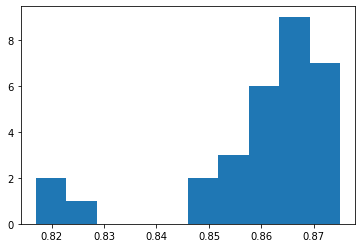

In [52]:
plt.hist(te_accuracies)
plt.show()